In [1]:
import os
import itertools
import psutil
import time
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
tf.get_logger().setLevel('ERROR')

2024-10-04 20:56:50.295922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 20:56:50.296018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 20:56:50.489520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/lymphoma-hda-dataset/Project_6"
classes = ["CLL", "FL", "MCL"]
num_classes = len(classes)
batch_size = 8
img_height, img_width = 640, 640

In [4]:
def load_data(root_dir, classes):
    images = []
    labels = []
    class_counts = {class_name: 0 for class_name in classes}
    
    print(f"Loading images from: {root_dir}")
    
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(glob(os.path.join(class_dir, "*.tif")))
        for image_path in glob(os.path.join(class_dir, "*.tif")):
            images.append(image_path)
            labels.append(label)

    print("Number of files in each class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")
    print(f"Total images and labels loaded: {len(images)}")
    labels = to_categorical(labels, num_classes=num_classes)
    
    return images, labels

In [5]:
images, labels = load_data(data_dir, classes)

Loading images from: /kaggle/input/lymphoma-hda-dataset/Project_6
Number of files in each class:
CLL: 113
FL: 139
MCL: 122
Total images and labels loaded: 374


In [6]:
def split_data(files, labels, ratio=0.05):
    X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=ratio, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=ratio * 2, random_state=42)
    print(f"Number of train images and labels: {len(X_train)}")
    print(f"Number of validation images and labels: {len(X_val)}")
    print(f"Number of test images and labels: {len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, labels)
train_len = len(X_train)

Number of train images and labels: 319
Number of validation images and labels: 36
Number of test images and labels: 19


In [8]:
def preprocess_image(image_path, label):
    image =  tfio.experimental.image.decode_tiff(tf.io.read_file(image_path))
    image =  tf.image.resize(image, [img_height, img_width])
    image = tf.ensure_shape(image, [img_height ,img_width, 4])
    image = tfio.experimental.color.rgba_to_rgb(image)
    return tf.cast(image, tf.float32) / 255., label

In [9]:
def create_dataset(images, labels, shuffle, cache, preprocess_funcs=[], repeat=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    for func in preprocess_funcs:
        dataset = dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache(cache)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)
    if repeat:    
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_dataset = create_dataset(X_train, y_train, shuffle = True, cache="training_set", preprocess_funcs=[preprocess_image], repeat=True)
val_dataset = create_dataset(X_val, y_val, shuffle = False, cache="validation_set", preprocess_funcs=[preprocess_image], repeat=False)
test_dataset = create_dataset(X_test, y_test, shuffle = False, cache="test_set", preprocess_funcs=[preprocess_image], repeat=False)

In [11]:
def plot_image(X_input, labels):
    plt.imshow(X_input, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

def label_decoder(label):
    if label[0] == 1:
        return 'CLL'
    if label[1] == 1:
        return 'FL'
    if label[2] == 1:
        return 'MCL'

LABEL: CLL


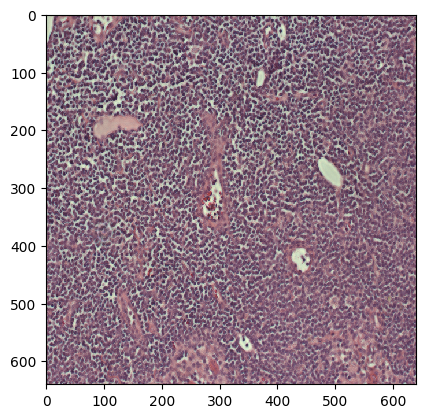

LABEL: CLL


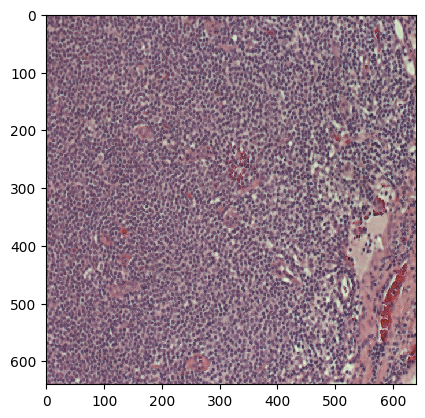

LABEL: MCL


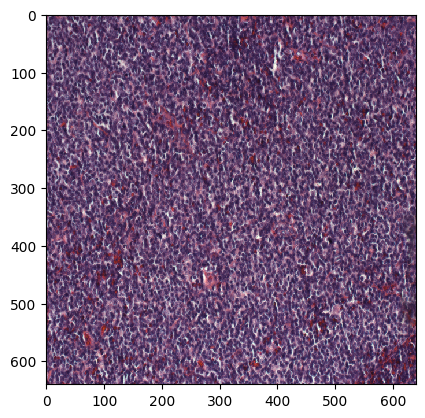

In [12]:
indices = np.random.randint(0, batch_size, (3,))
ds = train_dataset.take(1).get_single_element()
for index in indices:
    image = ds[0][index]
    label = label_decoder(ds[1][index])
    plot_image(image, label)

In [13]:
train_steps = int(np.ceil(train_len / batch_size))

val_steps = int(tf.data.experimental.cardinality(test_dataset).numpy())

test_steps = int(tf.data.experimental.cardinality(test_dataset).numpy())

In [14]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor, threshold, max_epochs, patience=3):
        super(EarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.max_epochs = max_epochs
        self.best_weights = None
        self.best_monitoring_value = float('-inf')
        self.wait = 0

    def on_train_begin(self, logs=None):
        # Initialize best weights to the model's initial weights
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        
        if current_value is None:
            raise ValueError(f"The metric {self.monitor} is not available in logs for early stopping.")
        
        # Check if max epochs are reached
        if epoch >= self.max_epochs - 1:
            print(f"\n--- Early stopping: Reached maximum number of epochs: {self.max_epochs} \n")
            self.model.set_weights(self.best_weights)
            self.model.stop_training = True
            return
        
        # Update best weights if current value is better
        if current_value > self.best_monitoring_value:
            self.best_weights = self.model.get_weights()
            self.best_monitoring_value = current_value
        
        # Reset wait counter if the current value is below the threshold
        if current_value < self.threshold:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True
                print(f"\n--- Early stopping: {self.monitor} has been more than {self.threshold} for {self.patience} epochs.\n")
                return


In [15]:
def plot_loss_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    return

def plot_accuracy_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    return

def plot_confusion_matrix(model, dataset, classes, test_steps):
    y_test_preds = model.predict(dataset, steps=test_steps)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in dataset], axis=0)
    y_test = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test, y_test_preds, labels=[i for i in range(len(classes))])
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [16]:
class TotalTimeMemoryCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.total_time = 0
        self.total_memory = 0
        
    def on_train_begin(self, logs=None):
        self.train_time_start = time.time()
        self.train_memory_start = psutil.Process().memory_info().rss / (1024 ** 2)

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.train_time_start
        self.total_memory = (psutil.Process().memory_info().rss / (1024 ** 2)) - self.train_memory_start

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.train_time_start
        epoch_memory = (psutil.Process().memory_info().rss / (1024 ** 2)) - self.train_memory_start
        print(f"Epoch {epoch + 1} - Time elapsed: {epoch_time:.2f} seconds, Memory used: {epoch_memory:.2f} MB")

# First Approach: DenseNet-121

In [22]:
class DenseNet121:
    def __conv_block(self, x, growth_rate):
        x1 = tf.keras.layers.BatchNormalization()(x)
        x1 = tf.keras.layers.Activation('relu')(x1)
        x1 = tf.keras.layers.Conv2D(4 * growth_rate, (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.Activation('relu')(x1)
        x1 = tf.keras.layers.Conv2D(growth_rate, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x1)
        return tf.keras.layers.concatenate([x, x1], axis=-1)
    
    def __dense_block(self, x, blocks, growth_rate):
        for _ in range(blocks):
            x = self.__conv_block(x, growth_rate)
        return x
    
    def __transition_block(self, x, reduction):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x)
        return tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    
    def __DenseNet121(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = self.__dense_block(x, 6, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 12, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 24, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 16, 32)

        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=x, name='DenseNet121')

    def create_model(self, input_shape):
        base_model = self.__DenseNet121(input_shape=input_shape)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(base_model.output)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='DenseNet121_Classifier')

In [23]:
densenet121 = DenseNet121().create_model(input_shape=(img_height, img_width, 3))
densenet121.summary()

Model: "DenseNet121_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 320, 320,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 320, 320,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 160, 160,  │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        256 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 160, 160,  │      8,320 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 160, 160,  │     36,896 │ activation_8[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160, 160,  │          0 │ max_pooling2d_6[… │
│ (Concatenate)       │ 96)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 160, 160,  │     12,416 │ activation_9[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 160, 160,  │          0 │ batch_normalizat

 Total params: 7,050,819 (26.90 MB)

 Trainable params: 6,967,171 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_densenet121.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 60

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.90, max_epochs=MAX_EPOCHS, patience=3)

In [25]:
densenet121.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), # Fixed
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [26]:
time_memory_callback = TotalTimeMemoryCallback()

densenet121_history = densenet121.fit(train_dataset,
                                epochs=MAX_EPOCHS,
                                steps_per_epoch=train_steps,
                                validation_data=val_dataset,
                                validation_steps=val_steps,
                                callbacks=[checkpoint, early_stopping, time_memory_callback],
                                verbose='auto')

Epoch 1/60


W0000 00:00:1728076314.361985     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4351 - loss: 3.1996 - precision_1: 0.4126 - recall_1: 0.2767

W0000 00:00:1728076353.263748     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to best_model_densenet121.keras
Epoch 1 - Time elapsed: 356.10 seconds, Memory used: 3749.03 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.4373 - loss: 3.1964 - precision_1: 0.4158 - recall_1: 0.2791 - val_accuracy: 0.2083 - val_loss: 3.1942 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.5303 - loss: 2.9276 - precision_1: 0.5908 - recall_1: 0.4788
Epoch 2: val_accuracy improved from 0.20833 to 0.41667, saving model to best_model_densenet121.keras


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 2 - Time elapsed: 404.38 seconds, Memory used: 3960.57 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5324 - loss: 2.9256 - precision_1: 0.5929 - recall_1: 0.4807 - val_accuracy: 0.4167 - val_loss: 3.1370 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7197 - loss: 2.7353 - precision_1: 0.8087 - recall_1: 0.6155
Epoch 3: val_accuracy did not improve from 0.41667
Epoch 3 - Time elapsed: 429.13 seconds, Memory used: 4400.55 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 618ms/step - accuracy: 0.7192 - loss: 2.7357 - precision_1: 0.8073 - recall_1: 0.6157 - val_accuracy: 0.3333 - val_loss: 3.2470 - val_precision_1: 0.3000 - val_recall_1: 0.1250
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.7372 - loss: 2.6661 - precision_1: 0.7716 - recall_1: 0.6548
Epoch 4: val_accuracy did not improve from 0.41667
Epoch 4 - Time elapsed: 454.18 seconds, Memory used: 4400.14 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 

In [27]:
print(f"Total training time: {time_memory_callback.total_time:.2f} seconds")
print(f"Total memory usage: {time_memory_callback.total_memory:.2f} MB")

Total training time: 1060.24 seconds
Total memory usage: 5300.30 MB


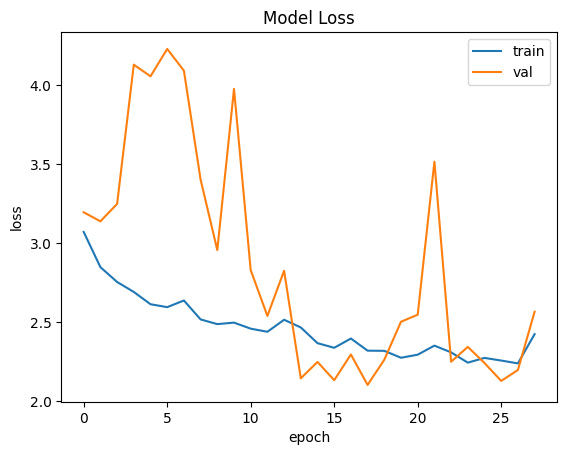

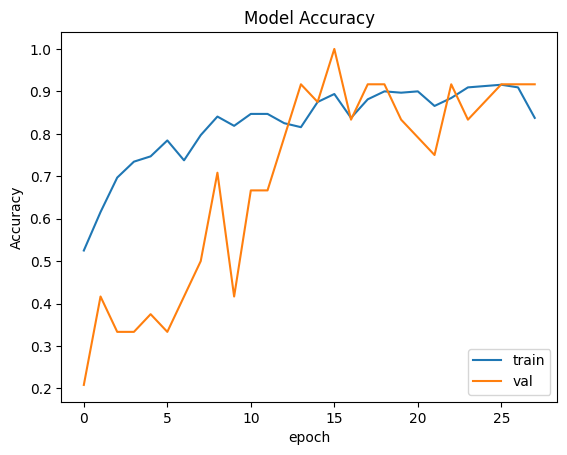

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

W0000 00:00:1728077079.382281     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step


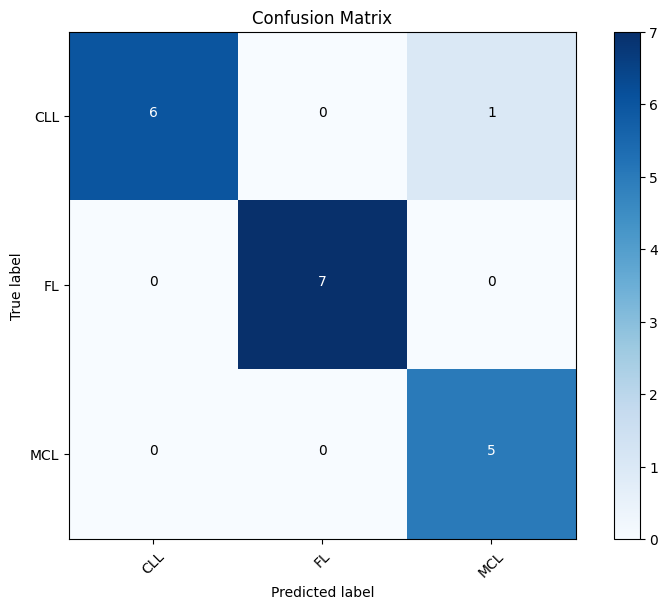

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9581 - loss: 2.2153 - precision_1: 0.9581 - recall_1: 0.9581 
DenseNet121 classifier evaluation results:

Testset Loss = 2.23001
Testset Accuracy = 0.95
Testset Precision = 0.95
Testset Recall = 0.95


In [28]:
plot_loss_curve(densenet121_history)
plot_accuracy_curve(densenet121_history)
plot_confusion_matrix(densenet121, test_dataset, classes, test_steps)
densenet121_score = densenet121.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("DenseNet121 classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(densenet121_score[0]))
print('Testset Accuracy = {:.2f}'.format(densenet121_score[1]))
print('Testset Precision = {:.2f}'.format(densenet121_score[2]))
print('Testset Recall = {:.2f}'.format(densenet121_score[3]))

# Second Approach: A CustomCNN Model

In [17]:
class CustomCNN:

    def __CustomCNN(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=x, name='CustomCNN')
    
    def create_model(self, input_shape):
        base_model = self.__CustomCNN(input_shape=input_shape)
        fc = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        fc = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(fc)
        fc = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(fc)
        fc = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(fc)
        fc = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))(fc)
        fc = tf.keras.layers.Dropout(0.4)(fc)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='CustomCNN-Classifier')

In [18]:
customcnn = CustomCNN().create_model(input_shape=(img_height, img_width, 3))
customcnn.summary()

Model: "CustomCNN-Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 640, 640, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 640, 640, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 640, 640, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 640, 640, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 320, 320, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 320, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 320, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 160, 160, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 160, 160, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80, 80, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 80, 80, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,601,987 (25.18 MB)

 Trainable params: 6,597,955 (25.17 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_customcnn.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.85, max_epochs=MAX_EPOCHS, patience=3)

customcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # Fixed
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

time_memory_callback = TotalTimeMemoryCallback()

customcnn_history = customcnn.fit(train_dataset,
                                epochs=MAX_EPOCHS,
                                steps_per_epoch=train_steps,
                                validation_data=val_dataset,
                                validation_steps=val_steps,
                                callbacks=[checkpoint, early_stopping, time_memory_callback],
                                verbose='auto')

Epoch 1/50


I0000 00:00:1728075682.712800     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1728075682.742158     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4296 - loss: 3.2577 - precision: 0.4051 - recall: 0.2455

W0000 00:00:1728075691.498544     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to best_model_customcnn.keras
Epoch 1 - Time elapsed: 51.66 seconds, Memory used: 2158.02 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 237ms/step - accuracy: 0.4307 - loss: 3.2540 - precision: 0.4072 - recall: 0.2466 - val_accuracy: 0.3750 - val_loss: 3.1259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4801 - loss: 3.0459 - precision: 0.5132 - recall: 0.3263
Epoch 2: val_accuracy did not improve from 0.37500
Epoch 2 - Time elapsed: 63.70 seconds, Memory used: 2392.88 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - accuracy: 0.4811 - loss: 3.0448 - precision: 0.5145 - recall: 0.3269 - val_accuracy: 0.3333 - val_loss: 3.1379 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
 1/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.6250 - loss: 2.9503 - precision: 0.6667 - recall: 0.2500

W0000 00:00:1728075704.181913     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5673 - loss: 2.9307 - precision: 0.6171 - recall: 0.3067
Epoch 3: val_accuracy did not improve from 0.37500
Epoch 3 - Time elapsed: 70.55 seconds, Memory used: 2688.59 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.5675 - loss: 2.9311 - precision: 0.6172 - recall: 0.3076 - val_accuracy: 0.3750 - val_loss: 3.1316 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6042 - loss: 2.8546 - precision: 0.6858 - recall: 0.4177
Epoch 4: val_accuracy did not improve from 0.37500
Epoch 4 - Time elapsed: 77.33 seconds, Memory used: 2745.40 MB
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.6048 - loss: 2.8544 - precision: 0.6860 - recall: 0.4182 - val_accuracy: 0.3333 - val_loss: 3.1840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6325 - loss: 2.8664 - precision: 0.7141 - recall: 0.4140


In [20]:
print(f"Total training time: {time_memory_callback.total_time:.2f} seconds")
print(f"Total memory usage: {time_memory_callback.total_memory:.2f} MB")

Total training time: 293.59 seconds
Total memory usage: 3759.83 MB


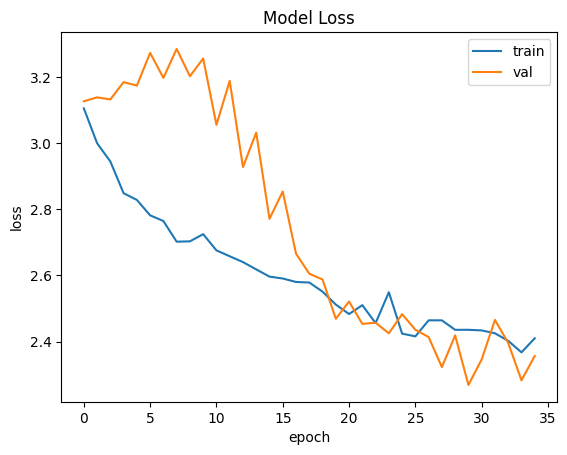

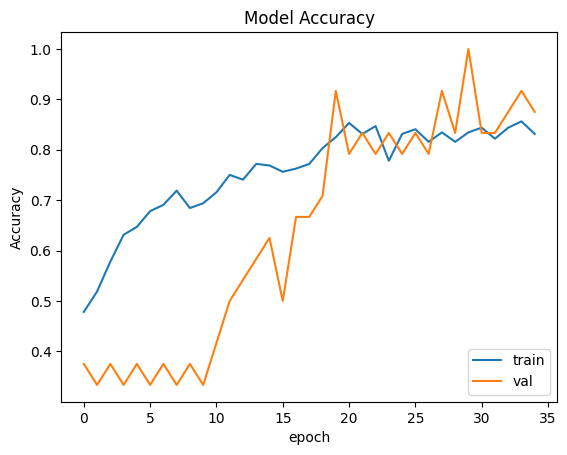

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

W0000 00:00:1728075957.523687     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step 


W0000 00:00:1728075961.609185     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


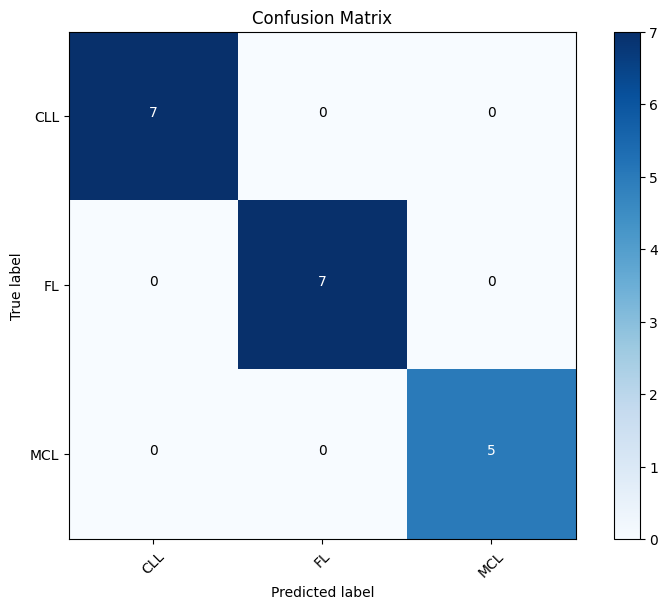

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 1.0000 - loss: 2.1659 - precision: 1.0000 - recall: 1.0000
Custom CNN classifier evaluation results:

Testset Loss = 2.14835
Testset Accuracy = 1.00
Testset Precision = 1.00
Testset Recall = 1.00


W0000 00:00:1728075963.504984     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [21]:
plot_loss_curve(customcnn_history)
plot_accuracy_curve(customcnn_history)
plot_confusion_matrix(customcnn, test_dataset, classes, test_steps)
customcnn_score = customcnn.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("Custom CNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(customcnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(customcnn_score[1]))
print('Testset Precision = {:.2f}'.format(customcnn_score[2]))
print('Testset Recall = {:.2f}'.format(customcnn_score[3]))